In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e19/sample_submission.csv
/kaggle/input/playground-series-s3e19/train.csv
/kaggle/input/playground-series-s3e19/test.csv


In [2]:
pip install statsforecast


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.7/370.7 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 10.0 MB/s eta 0:00:00
  Created wheel for fugue-sql-antlr: filename=fugue_sql_antlr-0.2.0-py3-none-any.whl size=158196 sha256=6c7b61a9a6e9d24739165143f16a4a2f4d1628c728d7b226bcf95d61d1c7a808
  Stored in directory: /root/.cache/pip/wheels/5a/b5/4e/216953a1c711da55de29ed7ecf158b4a5bf32ef93d69ad66dd
Successfully built fugue-sql-an

In [3]:
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA

/opt/conda/lib/python3.10/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/opt/conda/lib/python3.10/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [4]:
import matplotlib.pyplot as plt


In [5]:
# read the data
train = pd.read_csv('/kaggle/input/playground-series-s3e19/train.csv')
test = pd.read_csv("/kaggle/input/playground-series-s3e19/test.csv")
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e19/sample_submission.csv')

In [6]:
train.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [7]:
plt.rcParams["figure.figsize"] = (9,6)

In [8]:
#shape of train and test.
train.shape, test.shape

((136950, 6), (27375, 5))

In [9]:
train['date'].describe()

count         136950
unique          1826
top       2017-01-01
freq              75
Name: date, dtype: object

In [10]:
train['date'] = pd.to_datetime(train['date'])

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        136950 non-null  int64         
 1   date      136950 non-null  datetime64[ns]
 2   country   136950 non-null  object        
 3   store     136950 non-null  object        
 4   product   136950 non-null  object        
 5   num_sold  136950 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 6.3+ MB


In [12]:
train['unique_id'] = train.groupby(['country', 'store', 'product'], sort = False).ngroup()+1
train.unique_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75])

In [13]:
# set the date to be the index but we can see it is repeated 
train.set_index('date')

,id,country,store,product,num_sold,unique_id
date,,,,,,
2017-01-01,0,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,1
2017-01-01,1,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,2
2017-01-01,2,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,3
2017-01-01,3,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,4
2017-01-01,4,Argentina,Kaggle Learn,Using LLMs to Write Better,49,5
...,...,...,...,...,...,...
2021-12-31,136945,Spain,Kagglazon,Using LLMs to Improve Your Coding,700,71
2021-12-31,136946,Spain,Kagglazon,Using LLMs to Train More LLMs,752,72
2021-12-31,136947,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,111,73


In [14]:
# remove column id from the dataset
train = train.loc[:,train.columns !='id']

In [15]:
train.rename(columns= {'date': 'ds', 'num_sold':'y'}, inplace=True)
train.head()

,ds,country,store,product,y,unique_id
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,1
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,2
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,3
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,4
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49,5


In [16]:
train = train.drop(['country', 'store', 'product'], axis= 1)
train.head()

,ds,y,unique_id
0,2017-01-01,63,1
1,2017-01-01,66,2
2,2017-01-01,9,3
3,2017-01-01,59,4
4,2017-01-01,49,5


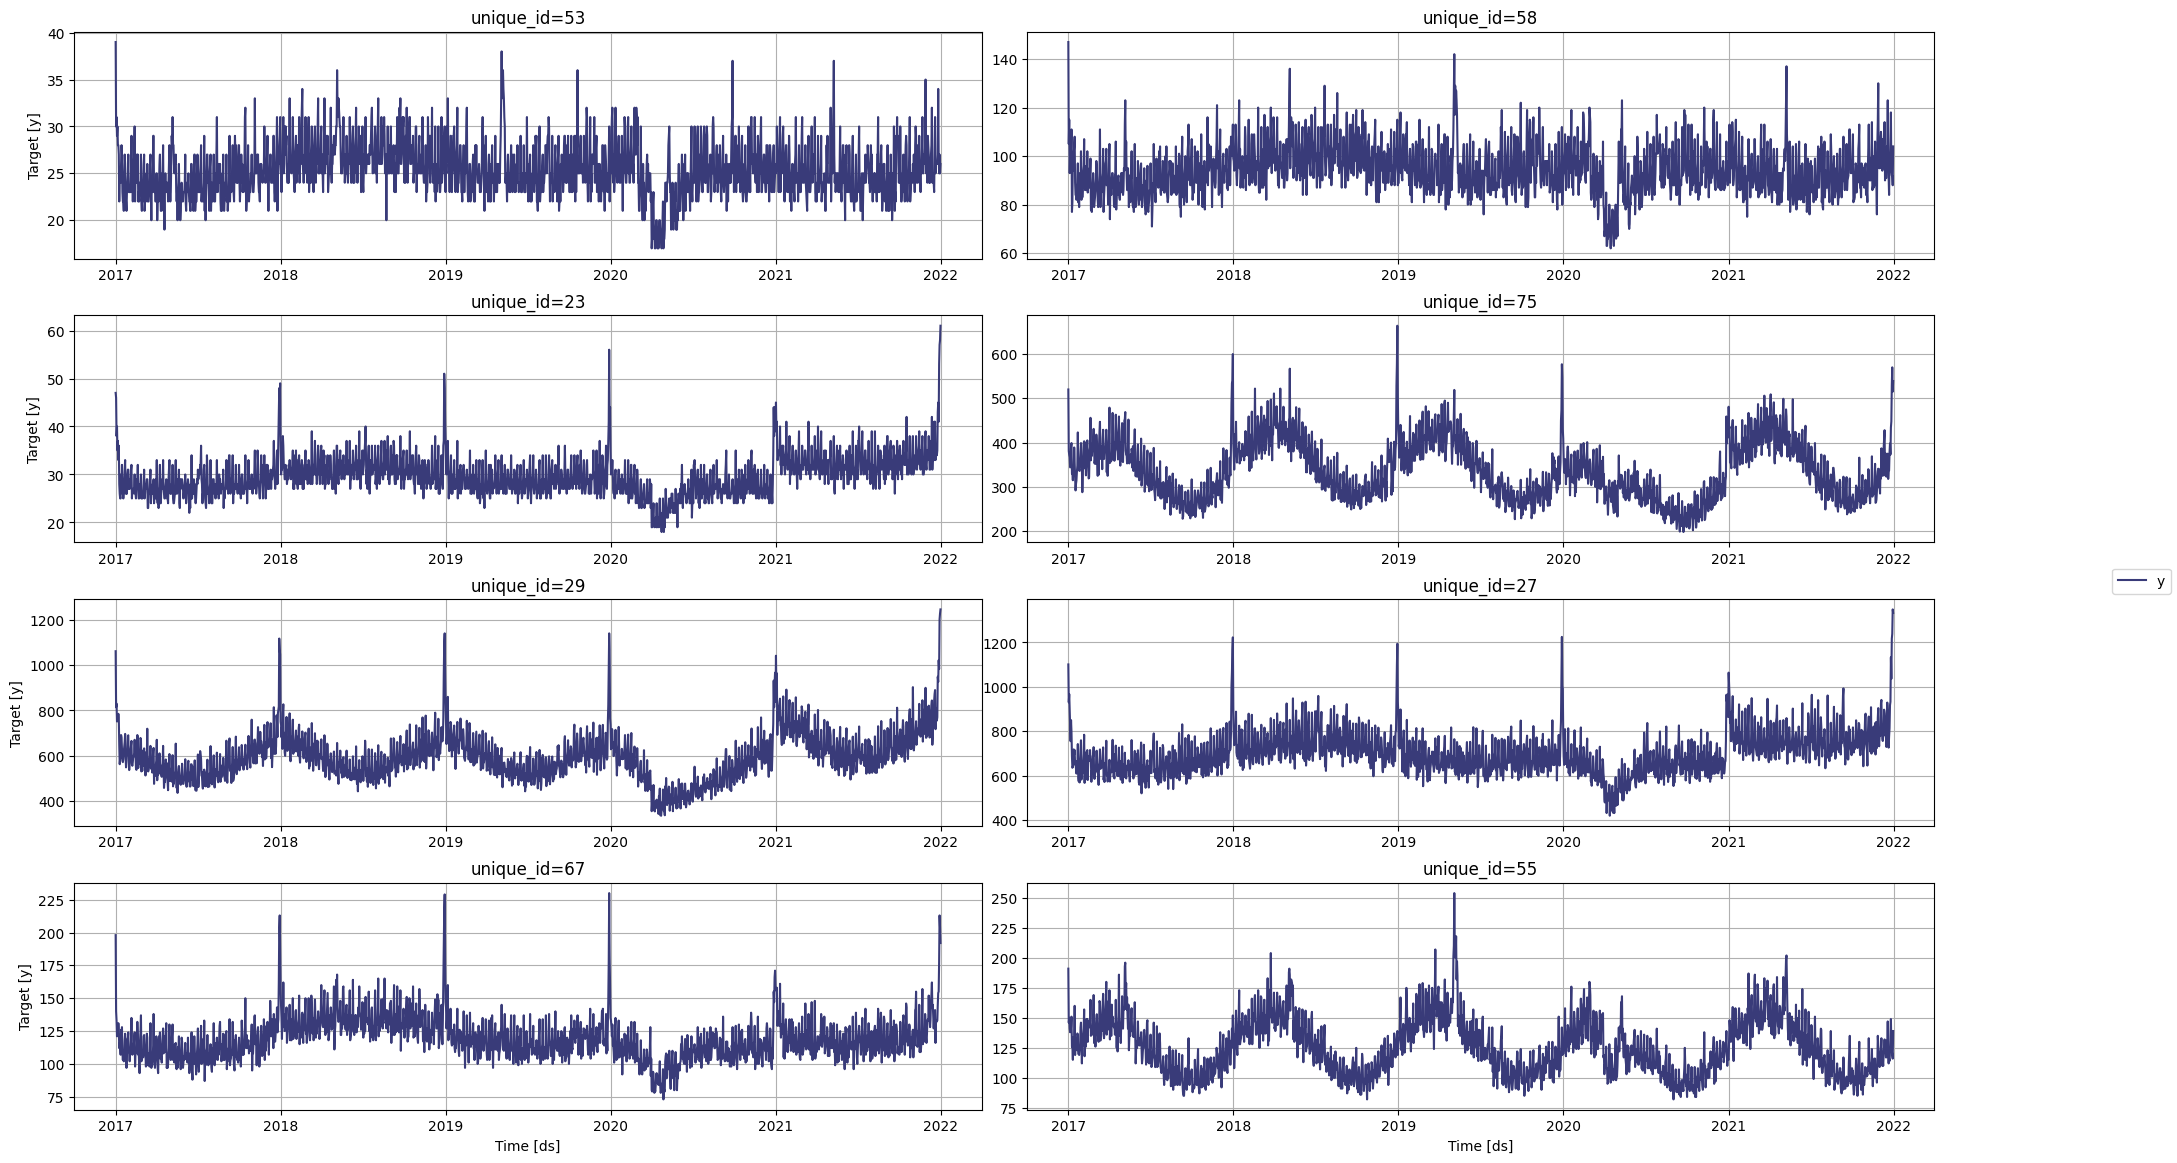

In [17]:
StatsForecast.plot(train)

Use MSTL model for the multiple seasonality

In [18]:
# Create an MSTL model  and instantiation parameters

models = [MSTL(
    season_length=[24, 24 * 7], # seasonalities of the time series weekly and annual
    trend_forecaster=AutoARIMA() # model used to forecast trend
)]


In [19]:
# StatsForecast MSTL model with weekly and annual seasonality
sf_mstl = StatsForecast(
    models = models,
    freq = 'D', n_jobs=-1
)

In [20]:
sf_mstl.fit(train)

StatsForecast(models=[MSTL])

In [21]:
# decompose the model 

sf_mstl.fitted_[0, 0].model_

,data,trend,seasonal24,seasonal168,remainder
0,63.0,34.630076,2.302991,8.262234,17.804699
1,51.0,34.637463,1.235489,0.561257,14.565791
2,44.0,34.645005,-0.046678,0.189118,9.212555
3,44.0,34.652703,0.277042,0.060341,9.009914
4,40.0,34.660557,0.337360,-0.380567,5.382650
...,...,...,...,...,...
1821,41.0,34.093182,1.047574,0.297365,5.561879
1822,38.0,34.118238,-0.096965,0.048183,3.930545
1823,46.0,34.143269,1.409161,0.693732,9.753838
1824,45.0,34.168277,0.990778,0.222412,9.618532


In [22]:
forecasts = sf_mstl.predict(h=365)
forecasts.head()

/opt/conda/lib/python3.10/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,MSTL
unique_id,,
1,2022-01-01,44.352329
1,2022-01-02,43.770370
1,2022-01-03,39.596340
1,2022-01-04,37.606094
1,2022-01-05,37.385036


In [23]:
forecasts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27375 entries, 1 to 75
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      27375 non-null  datetime64[ns]
 1   MSTL    27375 non-null  float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 534.7 KB


In [24]:
forecasts.reset_index(inplace = True)
forecasts

,unique_id,ds,MSTL
0,1,2022-01-01,44.352329
1,1,2022-01-02,43.770370
2,1,2022-01-03,39.596340
3,1,2022-01-04,37.606094
4,1,2022-01-05,37.385036
...,...,...,...
27370,75,2022-12-27,435.375427
27371,75,2022-12-28,433.495148
27372,75,2022-12-29,438.614624
27373,75,2022-12-30,462.146118


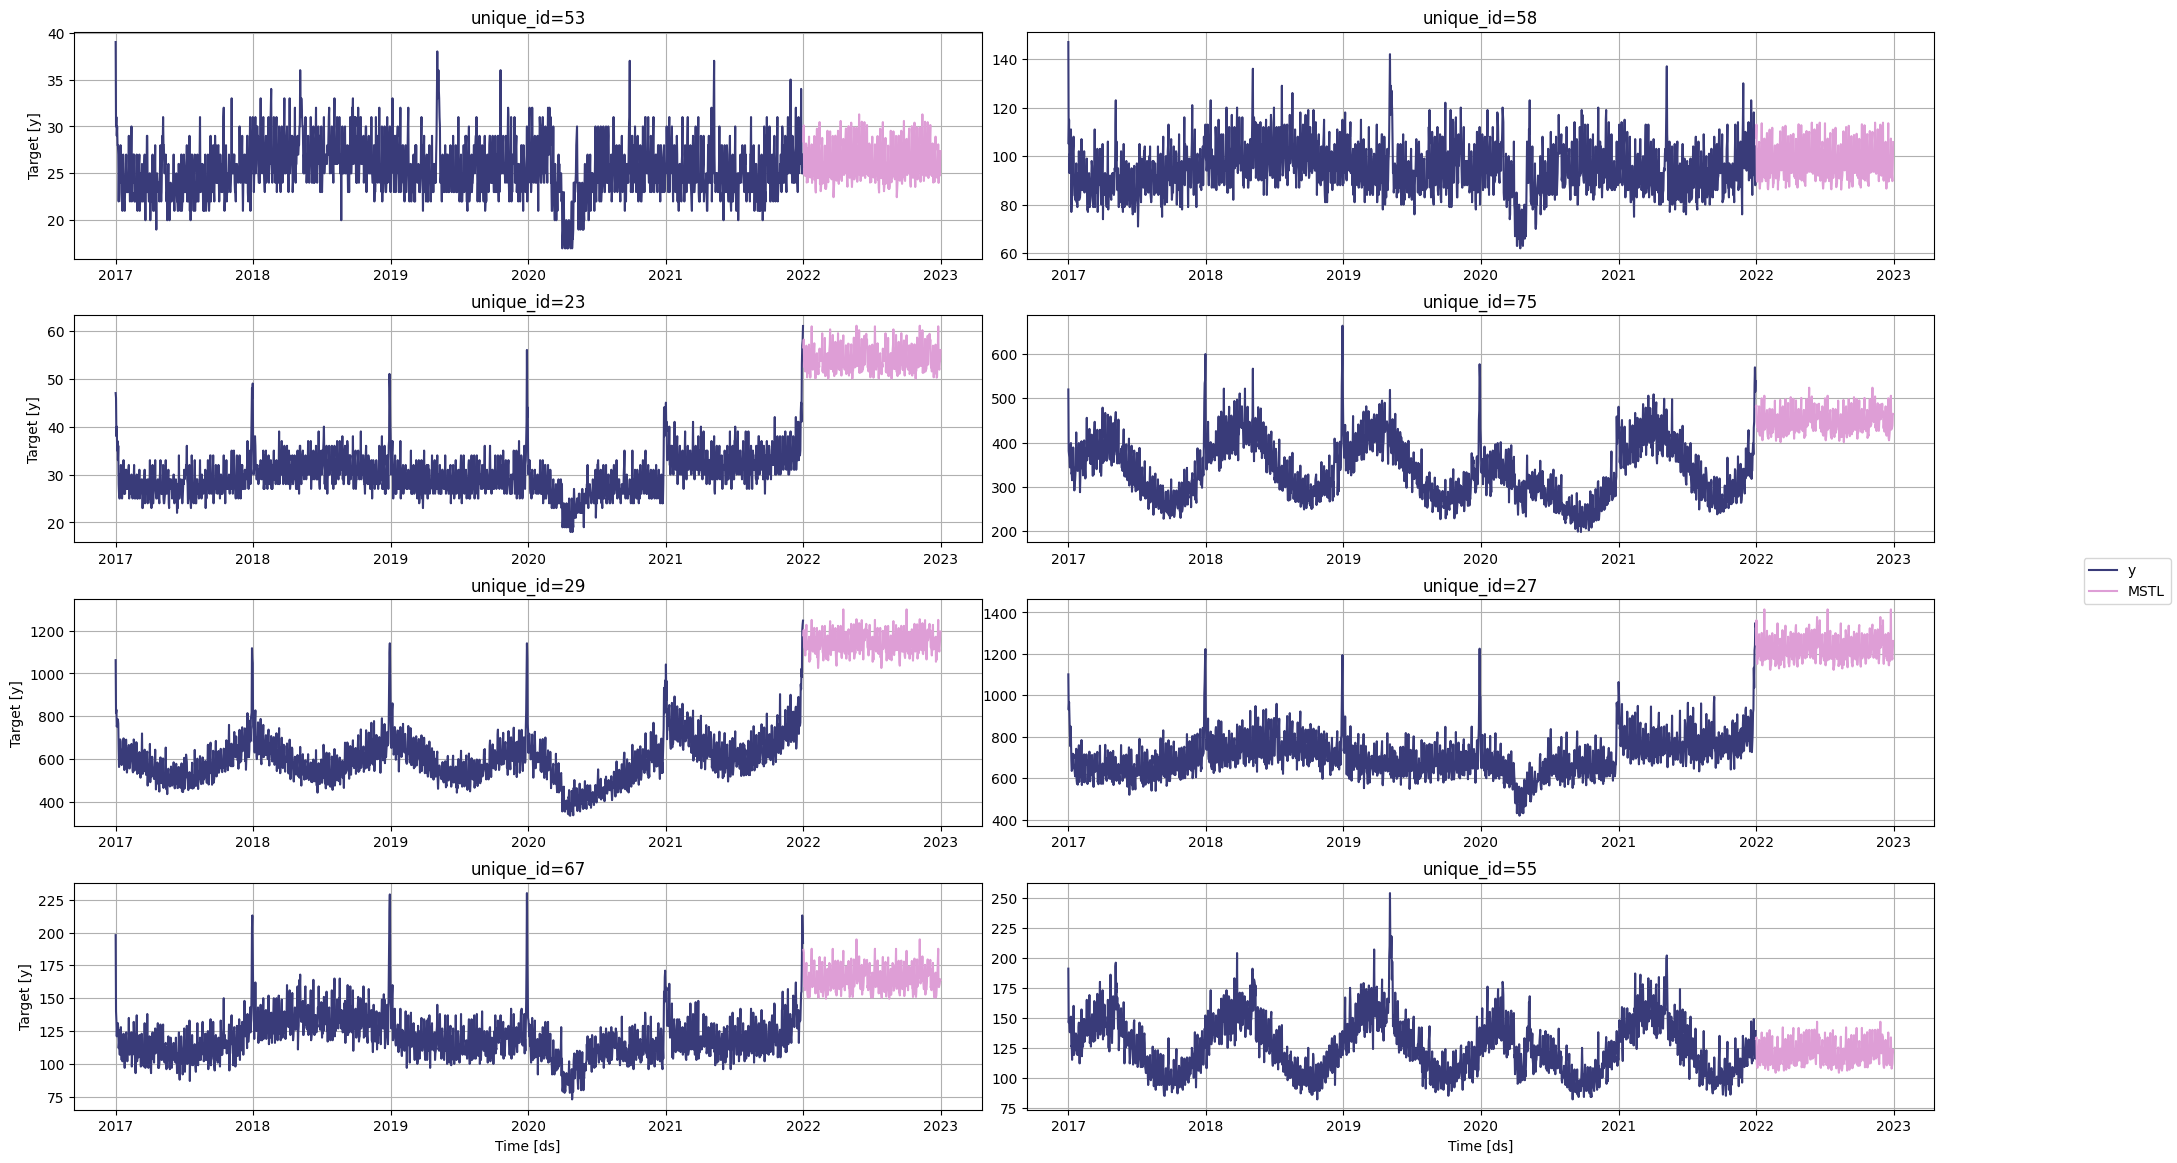

In [25]:
sf_mstl.plot(train, forecasts)

In [26]:
forecasts.shape, test.shape

((27375, 3), (27375, 5))

In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27375 entries, 0 to 27374
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       27375 non-null  int64 
 1   date     27375 non-null  object
 2   country  27375 non-null  object
 3   store    27375 non-null  object
 4   product  27375 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


In [28]:
test.head(20)

,id,date,country,store,product
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better
5,136955,2022-01-01,Argentina,Kaggle Store,Using LLMs to Improve Your Coding
6,136956,2022-01-01,Argentina,Kaggle Store,Using LLMs to Train More LLMs
7,136957,2022-01-01,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People
8,136958,2022-01-01,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions
9,136959,2022-01-01,Argentina,Kaggle Store,Using LLMs to Write Better


In [29]:
test['unique_id'] = test.groupby(['country', 'store', 'product'], sort = False).ngroup()+1
test.unique_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75])

In [30]:
# set the date to be the index but we can see it is repeated 
test['date'] = pd.to_datetime(test['date'])


In [31]:
test.sort_values(['unique_id', 'date'], ascending = [True, True], inplace = True)
test.head()

,id,date,country,store,product,unique_id
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,1
75,137025,2022-01-02,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,1
150,137100,2022-01-03,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,1
225,137175,2022-01-04,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,1
300,137250,2022-01-05,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,1


In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27375 entries, 0 to 27374
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         27375 non-null  int64         
 1   date       27375 non-null  datetime64[ns]
 2   country    27375 non-null  object        
 3   store      27375 non-null  object        
 4   product    27375 non-null  object        
 5   unique_id  27375 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.5+ MB


In [33]:
forecasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27375 entries, 0 to 27374
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  27375 non-null  int64         
 1   ds         27375 non-null  datetime64[ns]
 2   MSTL       27375 non-null  float32       
dtypes: datetime64[ns](1), float32(1), int64(1)
memory usage: 534.8 KB


In [34]:
final = forecasts.merge(test, how = 'left', left_on = ['unique_id', 'ds'], right_on = ['unique_id','date'])
final.head()

,unique_id,ds,MSTL,id,date,country,store,product
0,1,2022-01-01,44.352329,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
1,1,2022-01-02,43.770370,137025,2022-01-02,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
2,1,2022-01-03,39.596340,137100,2022-01-03,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
3,1,2022-01-04,37.606094,137175,2022-01-04,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
4,1,2022-01-05,37.385036,137250,2022-01-05,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding


In [35]:
submission = final[['id', 'MSTL']].sort_values('id')
submission['MSTL'] = submission['MSTL'].round(0)
submission.head()

,id,MSTL
0,136950,44.0
365,136951,43.0
730,136952,5.0
1095,136953,41.0
1460,136954,30.0


In [36]:
submission.to_csv('submission.csv')